# LETID - Outdoor Scenario Based on Accelerated Test

Example: Using a test result to model LETID progression in outdoor environments

Author: Joe Karas | joseph.karas@nrel.gov

2023
***

One important use case for this library is to use data from a LETID test (e.g. [IEC TS 63342](https://webstore.iec.ch/publication/67332)) to model how a module may degrade and regenerate in the field.

We will take some data from module testing presented in [Karas *et al.* 2022](https://onlinelibrary.wiley.com/doi/10.1002/pip.3573), and use it to estimate device parameters.

We can use the equations in this library to model LETID progression in a simulated outdoor environment, given that we have weather and system data. This example makes use of tools from the fabulous [pvlib](https://pvlib-python.readthedocs.io/en/stable/) library to calculate system irradiance and temperature, which we use to calculate progression in LETID states.



**Requirements:**
- `pvlib`, `pandas`, `numpy`, `matplotlib`, `scipy`

**Objectives:**
1. Load data from example test results
2. Use `pvlib` and provided weather files to set up a temperature and injection timeseries
3. Define necessary solar cell device parameters
4. Define necessary degradation parameters: degraded lifetime and defect states
5. Run through timeseries, calculating defect states
6. Calculate device degradation and plot


In [1]:
# if running on google colab, uncomment the next line and execute this cell to install the dependencies and prevent "ModuleNotFoundError" in later cells:
# !pip install pvdeg==0.1.1

In [1]:
from pvdeg import letid, collection, utilities, DATA_DIR

import pvlib
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

First, we'll load some data taken from an accelerated test. See [Karas *et al.* 2022](https://onlinelibrary.wiley.com/doi/10.1002/pip.3573) for full details. This data is the average of "Type S" modules from Lab 3. Type S modules were prototype modules made with 48 monocrystalline cells, and degraded about 4-5% in LETID testing. Data throughout testing is shown below:

In [2]:
cell_area = 243

In [5]:
df = pd.read_csv(os.path.join(DATA_DIR, 'module test data.csv'))
df['cell Voc'] = df['Voc']/48
df['Jsc'] = df['Isc']/cell_area*1000
df['% degradation'] = (df['Pmp']-df['Pmp'].iloc[0])/df['Pmp']*100
df

,Week,Pmp,Isc,Voc,FF,cell Voc,Jsc,% degradation
0,0,236.7,9.91,31.86,75.01,0.663750,40.781893,0.000000
1,1,230.9,9.82,31.63,74.38,0.658958,40.411523,-2.511910
2,2,228.5,9.72,31.54,74.50,0.657083,40.000000,-3.588621
3,3,226.9,9.70,31.56,74.10,0.657500,39.917695,-4.319083
4,4,224.8,9.62,31.48,74.22,0.655833,39.588477,-5.293594
5,7,235.8,9.76,31.98,75.51,0.666250,40.164609,-0.381679


The module parameter that is most sensitve to our device input parameters is cell open-circuit voltage, which in this case started at about 0.664 V/cell. We will select reasonable values for solar cell input parameters, and use ```letid.calc_voc_from_tau()``` to check if those parameters match the cell Voc of the device we're trying to model. The important quantities here are bulk lifetime in the initial state (```tau_0```), wafer thickness, and rear surface recombination velocity.

In [6]:
tau_0 = 120 # [us] reasonable bulk lifetime for commercial-quality p-type silicon, maybe a little on the low side for typical wafer lifetimes, which could range from 100-500 us.

wafer_thickness = 180 # [um] a reasonable wafer thickness for typical commercial silicon solar cells. Wafer thicknesses for Si solar cells are typically 160-180 um.

srv_rear = 100 # [cm/s] a reasonable value for rear surface recombination velocity for passivated emitter and rear cell (PERC) solar cells.
# Typical PERC cells might have a rear SRV anywhere from 50 to 100 cm/s. Higher values for early PERC, lower values for more modern, higher efficiency PERC.
# Other device structures will have different SRV values. E.g., aluminum back surface field (Al-BSF) cells could be ~500 cm/s. TopCON or other high efficiency cell structures will be lower, e.g. 10 cm/s.
# Note that all of these values are intepreted as "lumped" values for the entire rear surface.

isc_0 = df.query("Week == 0")['Isc'].item() # [A] we'll use the short circuit current from the Week 0 test data, instead of trying to calculate it
cell_area = 240.8 # [cm^2] typical cell size for 6-inch pseudosquare monocrystalline silicon  wafers
jsc_0 = isc_0/cell_area*1000 # [mA/cm^2] short circuit current density

temperature = 25 # [C] standard measurement temperature

voc_0 = letid.calc_voc_from_tau(tau_0, wafer_thickness, srv_rear, jsc_0, temperature)
voc_0


0.6611301062313933

In [7]:

generation_df = pd.read_excel(os.path.join(DATA_DIR, 'PVL_GenProfile.xlsx'), header = 0) # this is an optical generation profile generated by PVLighthouse's OPAL2 default model for 1-sun, normal incident AM1.5 sunlight on a 180-um thick SiNx-coated, pyramid-textured wafer.
generation = generation_df['Generation (cm-3s-1)']
depth = generation_df['Depth (um)']

d_base = 27 # cm^2/s electron diffusivity. See https://www2.pvlighthouse.com.au/calculators/mobility%20calculator/mobility%20calculator.aspx for details

Pretty close!

In [8]:
#check to make sure power is close to the measured Week 0 power

ff_0 = df.query("Week == 0")['FF'].item()# [%] fill factor

pmp_0 = (voc_0*48)*(jsc_0*cell_area/1000)*ff_0/100 # [W] maximum power
pmp_0, df.query("Week == 0")['Pmp'].item()

(235.89622533600513, 236.7)

Now we do the same thing for the degraded state to determine ```tau_deg```, the bulk lifetime when the module is in its most degraded state. So here the cell Voc target is the roughly 0.656 V measured after 4 weeks of testing.

In [9]:
tau_deg = 80 # [us] degraded bulk lifetime

isc_deg = df.query("Week == 4")['Isc'].item() # [A] we'll use the short circuit current from the Week 4 test data, instead of trying to calculate it
jsc_deg = isc_deg/cell_area*1000 # [mA/cm^2] short circuit current density

voc_deg = letid.calc_voc_from_tau(tau_deg, wafer_thickness, srv_rear, jsc_deg, temperature)
voc_deg


0.6538686361228122

In [10]:
#check to make sure power is close to the measured Week 4 power

ff_deg = df.query("Week == 4")['FF'].item()# [%] fill factor

pmp_deg = (voc_deg*48)*(jsc_deg*cell_area/1000)*ff_deg/100 # [W] maximum power
pmp_deg, df.query("Week == 4")['Pmp'].item()

(224.09272908700694, 224.8)

In [11]:
(pmp_0 - pmp_deg) / pmp_0

0.050036816961295416

So for modeling this module, we will use ```tau_0``` = 120 $\mu s$, ```tau_deg``` = 80 $\mu s$, with ```wafer_thickness``` = 180 $\mu m$ and ```srv_rear``` = 100 cm/s.

Great!

The example proceeds below in similar fashion to the outdoor example, using a fixed latitude tilt system at NREL, in Golden, CO, USA, using [NSRDB](https://nsrdb.nrel.gov/) hourly PSM weather data, SAPM temperature models, and module and inverter models from the CEC database.

In [12]:
# load weather and location data, use pvlib read_psm3 function

sam_file = os.path.join(DATA_DIR, 'psm3.csv')
weather, meta = pvlib.iotools.read_psm3(sam_file, map_variables = True)


In [13]:
weather

,Year,Month,Day,Hour,Minute,dni,dhi,ghi,temp_air,Dew Point,wind_speed,relative_humidity,poa_global,temp_cell,temp_module
1999-01-01 00:30:00-07:00,1999,1,1,0,30,0.0,0.0,0.0,0.0,-5.0,1.8,79.39,0.0,0.0,0.0
1999-01-01 01:30:00-07:00,1999,1,1,1,30,0.0,0.0,0.0,0.0,-4.0,1.7,80.84,0.0,0.0,0.0
1999-01-01 02:30:00-07:00,1999,1,1,2,30,0.0,0.0,0.0,0.0,-4.0,1.5,82.98,0.0,0.0,0.0
1999-01-01 03:30:00-07:00,1999,1,1,3,30,0.0,0.0,0.0,0.0,-4.0,1.3,85.01,0.0,0.0,0.0
1999-01-01 04:30:00-07:00,1999,1,1,4,30,0.0,0.0,0.0,0.0,-4.0,1.3,85.81,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999-12-31 19:30:00-07:00,1999,12,31,19,30,0.0,0.0,0.0,0.0,-3.0,0.9,83.63,0.0,0.0,0.0
1999-12-31 20:30:00-07:00,1999,12,31,20,30,0.0,0.0,0.0,0.0,-3.0,1.2,86.82,0.0,0.0,0.0
1999-12-31 21:30:00-07:00,1999,12,31,21,30,0.0,0.0,0.0,0.0,-4.0,1.6,83.78,0.0,0.0,0.0
1999-12-31 22:30:00-07:00,1999,12,31,22,30,0.0,0.0,0.0,0.0,-4.0,1.7,81.22,0.0,0.0,0.0


In [14]:
#if our weather file doesn't have precipitable water, calculate it with pvlib
if not 'precipitable_water' in weather.columns:
    weather['precipitable_water'] = pvlib.atmosphere.gueymard94_pw(weather['temp_air'], weather['relative_humidity'])

In [15]:
# drop unneeded columns
weather = weather[['ghi', 'dni', 'dhi', 'temp_air', 'wind_speed', 'relative_humidity', 'precipitable_water']]

In [16]:
weather

,ghi,dni,dhi,temp_air,wind_speed,relative_humidity,precipitable_water
1999-01-01 00:30:00-07:00,0.0,0.0,0.0,0.0,1.8,79.39,0.891869
1999-01-01 01:30:00-07:00,0.0,0.0,0.0,0.0,1.7,80.84,0.908158
1999-01-01 02:30:00-07:00,0.0,0.0,0.0,0.0,1.5,82.98,0.932199
1999-01-01 03:30:00-07:00,0.0,0.0,0.0,0.0,1.3,85.01,0.955004
1999-01-01 04:30:00-07:00,0.0,0.0,0.0,0.0,1.3,85.81,0.963991
...,...,...,...,...,...,...,...
1999-12-31 19:30:00-07:00,0.0,0.0,0.0,0.0,0.9,83.63,0.939501
1999-12-31 20:30:00-07:00,0.0,0.0,0.0,0.0,1.2,86.82,0.975338
1999-12-31 21:30:00-07:00,0.0,0.0,0.0,0.0,1.6,83.78,0.941186
1999-12-31 22:30:00-07:00,0.0,0.0,0.0,0.0,1.7,81.22,0.912427


### Set up PVlib model
Note that the module we select here is NOT the same "Type S" module that was tested for LETID. I'm simply trying to find a module in the CEC database with I-V characteristics that are reasonably close to the tested module, so the pvlib calculated DC results are close to how our Type S module might behave in the field.

In [17]:
cec_modules = pvlib.pvsystem.retrieve_sam('CECMod').T
cec_modules[cec_modules['STC'].between(220, 250) & (cec_modules['N_s'] == 48)]

,Technology,Bifacial,STC,PTC,A_c,Length,Width,N_s,I_sc_ref,V_oc_ref,...,a_ref,I_L_ref,I_o_ref,R_s,R_sh_ref,Adjust,gamma_r,BIPV,Version,Date
Gintech_Energy_GIN_M6_48_220,Mono-c-Si,0,220.48,194.5,1.313,1.324,0.992,48,9.31,31.3,...,1.521151,9.3228,0.0,0.106087,77.164063,22.488531,-0.55,N,SAM 2018.11.11 r2,1/3/2019
Gintech_Energy_GIN_P6_48_220,Multi-c-Si,0,220.378,199.2,1.313,1.324,0.992,48,9.28,31.3,...,1.379815,9.379174,0.0,0.254869,374.724518,8.824213,-0.49,N,SAM 2018.11.11 r2,1/3/2019
Gintech_Energy_GIN_M6_48_225,Mono-c-Si,0,225.844,199.1,1.313,1.324,0.992,48,9.45,31.5,...,1.530596,9.461989,0.0,0.100905,79.531746,22.462965,-0.55,N,SAM 2018.11.11 r2,1/3/2019
LG_Electronics_Inc__LG230N8K_G4,Mono-c-Si,0,230.127,212.9,1.274,1.3,0.98,48,9.9,30.0,...,1.110894,10.312051,0.0,0.307502,314.551514,2.112491,-0.38,N,SAM 2018.11.11 r2,1/3/2019
LG_Electronics_Inc__LG235N8K_G4,Mono-c-Si,0,235.216,217.6,1.274,1.3,0.98,48,9.96,30.2,...,1.124688,10.375943,0.0,0.278936,250.799469,3.374386,-0.38,N,SAM 2018.11.11 r2,1/3/2019
LG_Electronics_Inc__LG240N8K_G4,Mono-c-Si,0,240.1,222.4,1.274,1.3,0.98,48,10.01,30.5,...,1.134983,10.313996,0.0,0.263453,3976.513916,3.244429,-0.38,N,SAM 2018.11.11 r2,1/3/2019
LG_Electronics_Inc__LG245N8K_G4,Mono-c-Si,0,245.016,227.1,1.274,1.3,0.98,48,10.06,30.8,...,1.150454,10.36712,0.0,0.246041,1112.830811,4.077489,-0.38,N,SAM 2018.11.11 r2,1/3/2019
Prism_Solar_Technologies_Bi48_279BSTC,Mono-c-Si,1,220.472,199.3,1.668,1.695,0.984,48,9.15,31.0,...,1.266369,9.15029,0.0,0.210912,6628.005371,13.999823,-0.4399,N,SAM 2018.11.11 r2,1/3/2019
Prism_Solar_Technologies_Bi48_286BSTC,Mono-c-Si,1,225.298,204.0,1.668,1.695,0.984,48,9.35,31.0,...,1.266347,9.350275,0.0,0.206403,7016.816406,13.996228,-0.4399,N,SAM 2018.11.11 r2,1/3/2019


The LG ones look close to the module we're trying to model. Pmp around 235W, Isc around 9.9A. Let's go with 'LG_Electronics_Inc__LG235N8K_G4'

In [18]:
cec_modules = cec_modules.T
cec_module = cec_modules['LG_Electronics_Inc__LG235N8K_G4']

In [19]:
# import the rest of the pvlib stuff
# we'll use the SAPM temperature model open-rack glass/polymer coeffecients. 

from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS
from pvlib.location import Location
from pvlib.pvsystem import PVSystem
from pvlib.modelchain import ModelChain

cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')
cec_inverter = cec_inverters['ABB__ULTRA_750_TL_OUTD_1_US_690_x_y_z__690V_']

temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_polymer']


In [20]:
# set up system in pvlib
lat = meta['latitude']
lon = meta['longitude']
tz = meta['Local Time Zone']
elevation = meta['altitude']
surface_tilt = lat # fixed, latitude tilt
surface_azimuth = 180 # south-facing

location = Location(lat, lon, tz, elevation, 'Golden, CO, USA')

system = PVSystem(surface_tilt = surface_tilt, surface_azimuth = surface_azimuth,
                  module_parameters = cec_module,
                  inverter_parameters = cec_inverter,
                  temperature_model_parameters = temperature_model_parameters,
                  )

In [21]:
# create and run pvlib modelchain
mc = ModelChain(system, location, aoi_model = "physical")
mc.run_model(weather)

ModelChain: 
  name: None
  clearsky_model: ineichen
  transposition_model: haydavies
  solar_position_method: nrel_numpy
  airmass_model: kastenyoung1989
  dc_model: cec
  ac_model: sandia_inverter
  aoi_model: physical_aoi_loss
  spectral_model: first_solar_spectral_loss
  temperature_model: sapm_temp
  losses_model: no_extra_losses

## Set up timeseries
In this example, injection is a function of both the operating point of the module (which we will assume is maximum power point) and irradiance. Maximum power point injection is equivalent to $(I_{sc}-I_{mp})/I_{sc}\times Ee$, where $Ee$ is effective irradiance, the irradiance absorbed by the module's cells. We normalize it to 1-sun irradiance, 1000 $W/m^2$.

We will use the irradiance, DC operating point, and cell temperature from the pvlib modelchain results.

In [22]:
ee = mc.results.effective_irradiance
injection = (mc.results.dc['i_sc']-mc.results.dc['i_mp'])/(mc.results.dc['i_sc'])*(ee/1000)
temperature = mc.results.cell_temperature

timesteps = pd.DataFrame({'Temperature':temperature, 'Injection':injection}) # create a DataFrame with cell temperature and injection
timesteps.reset_index(inplace = True) # reset the index so datetime is a column. I prefer integer indexing.
timesteps.rename(columns = {'index':'Datetime'}, inplace = True)


##### Remaining degradation parameters:
We've already set our important device parameters: ```tau_0```, ```tau_deg```, ```wafer_thickness```, ```srv_rear```, ```cell_area```, etc, but we need a few more: generation profile and carrier diffusivity. These are necessary for calculating current collection, and the "default" values provided here should be sufficient for most use cases.

The rest of the quantities to define are: the initial percentage of defects in each state (A, B, and C), and the dictionary of mechanism parameters.

In this example, we'll assume the device starts in the fully-undegraded state (100% state A), and we'll use the parameters for LETID degradation from Repins.

In [23]:
generation_df = pd.read_excel(os.path.join(DATA_DIR, 'PVL_GenProfile.xlsx'), header = 0) # this is an optical generation profile generated by PVLighthouse's OPAL2 default model for 1-sun, normal incident AM1.5 sunlight on a 180-um thick SiNx-coated, pyramid-textured wafer.
generation = generation_df['Generation (cm-3s-1)']
depth = generation_df['Depth (um)']

d_base = 27 # cm^2/s electron diffusivity. See https://www2.pvlighthouse.com.au/calculators/mobility%20calculator/mobility%20calculator.aspx for details

In [24]:
# starting defect state percentages
nA_0 = 100
nB_0 = 0
nC_0 = 0

mechanism_params = utilities.get_kinetics('repins')

timesteps[['NA', 'NB', 'NC', 'tau']] = np.nan # create columns for defect state percentages and lifetime, fill with NaNs for now, to fill iteratively below

timesteps.loc[0, ['NA', 'NB', 'NC']] = nA_0, nB_0, nC_0 # assign first timestep defect state percentages
timesteps.loc[0, 'tau'] = letid.tau_now(tau_0, tau_deg, nB_0) # calculate tau for the first timestep

In [25]:
timesteps

,Datetime,Temperature,Injection,NA,NB,NC,tau
0,1999-01-01 00:30:00-07:00,0.0,NaN,100.0,0.0,0.0,120.0
1,1999-01-01 01:30:00-07:00,0.0,NaN,NaN,NaN,NaN,NaN
2,1999-01-01 02:30:00-07:00,0.0,NaN,NaN,NaN,NaN,NaN
3,1999-01-01 03:30:00-07:00,0.0,NaN,NaN,NaN,NaN,NaN
4,1999-01-01 04:30:00-07:00,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
8755,1999-12-31 19:30:00-07:00,0.0,NaN,NaN,NaN,NaN,NaN
8756,1999-12-31 20:30:00-07:00,0.0,NaN,NaN,NaN,NaN,NaN
8757,1999-12-31 21:30:00-07:00,0.0,NaN,NaN,NaN,NaN,NaN
8758,1999-12-31 22:30:00-07:00,0.0,NaN,NaN,NaN,NaN,NaN


## Run through timesteps
Since each timestep depends on the preceding timestep, we need to calculate in a loop. This will take a few minutes depending on the length of the timeseries.

In [26]:
for index, timestep in timesteps.iterrows():
    
    # first row tau has already been assigned
    if index == 0:
        pass
    
    # loop through rows, new tau calculated based on previous NB. Reaction proceeds based on new tau.
    else:
        n_A = timesteps.at[index-1, 'NA']
        n_B = timesteps.at[index-1, 'NB']
        n_C = timesteps.at[index-1, 'NC']

        tau = letid.tau_now(tau_0, tau_deg, n_B)
        jsc = collection.calculate_jsc_from_tau_cp(tau, wafer_thickness, d_base, srv_rear, generation, depth)
        
        temperature = timesteps.at[index, 'Temperature']
        injection = timesteps.at[index, 'Injection']

        # calculate defect reaction kinetics: reaction constant and carrier concentration factor.
        k_AB = letid.k_ij(mechanism_params['v_ab'], mechanism_params['ea_ab'], temperature)
        k_BA = letid.k_ij(mechanism_params['v_ba'], mechanism_params['ea_ba'], temperature)
        k_BC = letid.k_ij(mechanism_params['v_bc'], mechanism_params['ea_bc'], temperature)
        k_CB = letid.k_ij(mechanism_params['v_cb'], mechanism_params['ea_cb'], temperature)

        x_ab = letid.carrier_factor(tau, 'ab', temperature, injection, jsc, wafer_thickness, srv_rear, mechanism_params)
        x_ba = letid.carrier_factor(tau, 'ba', temperature, injection, jsc, wafer_thickness, srv_rear, mechanism_params)
        x_bc = letid.carrier_factor(tau, 'bc', temperature, injection, jsc, wafer_thickness, srv_rear, mechanism_params)

        # calculate the instantaneous change in NA, NB, and NC
        dN_Adt = (k_BA * n_B * x_ba) - (k_AB * n_A * x_ab)
        dN_Bdt = (k_AB * n_A * x_ab) + (k_CB * n_C) - ((k_BA * x_ba + k_BC * x_bc) * n_B)
        dN_Cdt = (k_BC * n_B * x_bc) - (k_CB * n_C)

        t_step = (timesteps.at[index, 'Datetime'] - timesteps.at[index-1,'Datetime']).total_seconds()
        
        # assign new defect state percentages
        timesteps.at[index, 'NA'] = n_A + dN_Adt*t_step
        timesteps.at[index, 'NB'] = n_B + dN_Bdt*t_step
        timesteps.at[index, 'NC'] = n_C + dN_Cdt*t_step

In [27]:
timesteps['tau'] = letid.tau_now(tau_0, tau_deg, timesteps['NB'])

# calculate device Jsc for every timestep. Unfortunately this requires an integration so I think we have to run through a loop. Device Jsc allows calculation of device Voc.
for index, timestep in timesteps.iterrows():
    jsc_now = collection.calculate_jsc_from_tau_cp(timesteps.at[index, 'tau'], wafer_thickness, d_base, srv_rear, generation, depth)
    timesteps.at[index, 'Jsc'] = jsc_now
    timesteps.at[index, 'Voc'] = letid.calc_voc_from_tau(timesteps.at[index, 'tau'], wafer_thickness, srv_rear, jsc_now, temperature = 25)


In [28]:
timesteps = letid.calc_device_params(timesteps, cell_area) # this function quickly calculates the rest of the device parameters: Isc, FF, max power, and normalized max power

timesteps


,Datetime,Temperature,Injection,NA,NB,NC,tau,Jsc,Voc,Isc,FF,Pmp,Pmp_norm
0,1999-01-01 00:30:00-07:00,0.0,NaN,100.000000,0.000000e+00,0.000000e+00,120.000000,41.454173,0.661317,9.982165,0.840102,5.545822,1.000000
1,1999-01-01 01:30:00-07:00,0.0,NaN,100.000000,1.683090e-15,0.000000e+00,120.000000,41.454173,0.661317,9.982165,0.840102,5.545822,1.000000
2,1999-01-01 02:30:00-07:00,0.0,NaN,100.000000,3.366181e-15,5.269266e-36,120.000000,41.454173,0.661317,9.982165,0.840102,5.545822,1.000000
3,1999-01-01 03:30:00-07:00,0.0,NaN,100.000000,5.049271e-15,1.580780e-35,120.000000,41.454173,0.661317,9.982165,0.840102,5.545822,1.000000
4,1999-01-01 04:30:00-07:00,0.0,NaN,100.000000,6.732362e-15,3.161560e-35,120.000000,41.454173,0.661317,9.982165,0.840102,5.545822,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,1999-12-31 19:30:00-07:00,0.0,NaN,30.469717,6.606672e+01,3.463559e+00,90.202937,41.346420,0.656763,9.956218,0.839288,5.487995,0.989573
8756,1999-12-31 20:30:00-07:00,0.0,NaN,30.469717,6.606672e+01,3.463559e+00,90.202937,41.346420,0.656763,9.956218,0.839288,5.487995,0.989573
8757,1999-12-31 21:30:00-07:00,0.0,NaN,30.469717,6.606672e+01,3.463559e+00,90.202937,41.346420,0.656763,9.956218,0.839288,5.487995,0.989573
8758,1999-12-31 22:30:00-07:00,0.0,NaN,30.469717,6.606672e+01,3.463559e+00,90.202937,41.346420,0.656763,9.956218,0.839288,5.487995,0.989573


Note of course that all these calculated device parameters are modeled STC device parameters, not the instantaneous, weather-dependent values. We'll merge back in the pvlib results for convenience, but these don't reflect the device degradation. We'll calculate energy loss next

In [29]:
timesteps = timesteps.merge(mc.results.dc, left_on = 'Datetime', right_index=True)
timesteps = timesteps.merge(pd.DataFrame(mc.results.effective_irradiance, columns= ['Effective irradiance']), left_on = 'Datetime', right_index=True)
timesteps = timesteps.merge(mc.results.weather, left_on = 'Datetime', right_index=True)

timesteps


,Datetime,Temperature,Injection,NA,NB,NC,tau,Jsc,Voc,Isc,...,p_mp,i_x,i_xx,Effective irradiance,ghi,dhi,dni,wind_speed,temp_air,precipitable_water
0,1999-01-01 00:30:00-07:00,0.0,NaN,100.000000,0.000000e+00,0.000000e+00,120.000000,41.454173,0.661317,9.982165,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,1.8,0.0,0.891869
1,1999-01-01 01:30:00-07:00,0.0,NaN,100.000000,1.683090e-15,0.000000e+00,120.000000,41.454173,0.661317,9.982165,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,1.7,0.0,0.908158
2,1999-01-01 02:30:00-07:00,0.0,NaN,100.000000,3.366181e-15,5.269266e-36,120.000000,41.454173,0.661317,9.982165,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,1.5,0.0,0.932199
3,1999-01-01 03:30:00-07:00,0.0,NaN,100.000000,5.049271e-15,1.580780e-35,120.000000,41.454173,0.661317,9.982165,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,1.3,0.0,0.955004
4,1999-01-01 04:30:00-07:00,0.0,NaN,100.000000,6.732362e-15,3.161560e-35,120.000000,41.454173,0.661317,9.982165,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,1.3,0.0,0.963991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,1999-12-31 19:30:00-07:00,0.0,NaN,30.469717,6.606672e+01,3.463559e+00,90.202937,41.346420,0.656763,9.956218,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.9,0.0,0.939501
8756,1999-12-31 20:30:00-07:00,0.0,NaN,30.469717,6.606672e+01,3.463559e+00,90.202937,41.346420,0.656763,9.956218,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,1.2,0.0,0.975338
8757,1999-12-31 21:30:00-07:00,0.0,NaN,30.469717,6.606672e+01,3.463559e+00,90.202937,41.346420,0.656763,9.956218,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,1.6,0.0,0.941186
8758,1999-12-31 22:30:00-07:00,0.0,NaN,30.469717,6.606672e+01,3.463559e+00,90.202937,41.346420,0.656763,9.956218,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,1.7,0.0,0.912427


### Plot the results

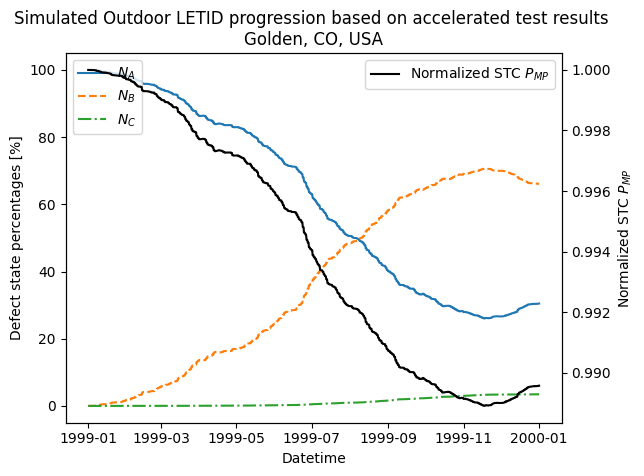

In [30]:
from cycler import cycler
plt.style.use('default')

fig, ax = plt.subplots()

ax.set_prop_cycle(cycler('color', ['tab:blue', 'tab:orange', 'tab:green']) + cycler('linestyle', ['-', '--', '-.']))

ax.plot(timesteps['Datetime'], timesteps[['NA', 'NB', 'NC']].values)
ax.legend(labels = ['$N_A$', '$N_B$', '$N_C$'], loc = 'upper left')
ax.set_ylabel('Defect state percentages [%]')
ax.set_xlabel('Datetime')

ax2 = ax.twinx()
ax2.plot(timesteps['Datetime'], timesteps['Pmp_norm'], c = 'black', label = 'Normalized STC $P_{MP}$')
ax2.legend(loc = 'upper right')
ax2.set_ylabel('Normalized STC $P_{MP}$')

ax.set_title('Simulated Outdoor LETID progression based on accelerated test results \n'f'{location.name}')

plt.show()

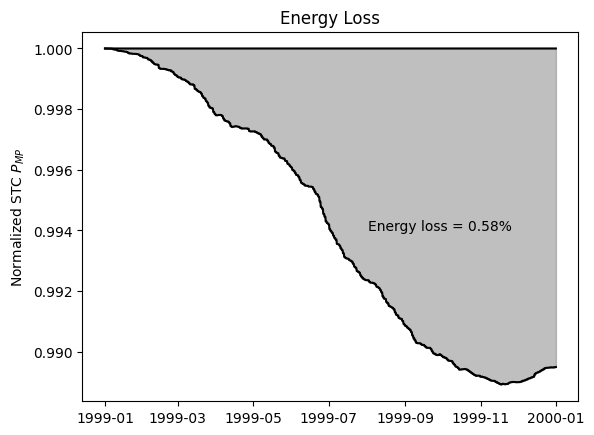

In [37]:
import matplotlib.dates as mdates
plt.style.use('default')

fig, ax = plt.subplots()

ax.plot(timesteps['Datetime'], timesteps['Pmp_norm'], c = 'black', label = 'Normalized STC $P_{MP}$')
ax.plot(timesteps['Datetime'], np.ones(len(timesteps)), c = 'black')
ax.fill_between(timesteps['Datetime'], np.ones(len(timesteps)), timesteps['Pmp_norm'], color = 'grey', alpha = 0.5)


ax.set_ylabel('Normalized STC $P_{MP}$')

ax.set_title('Energy Loss')

loss = letid.calc_energy_loss(timesteps)

ax.text(mdates.datestr2num('1999-08-02'), .994, s = f"Energy loss = {loss*100:.2f}%")

plt.show()

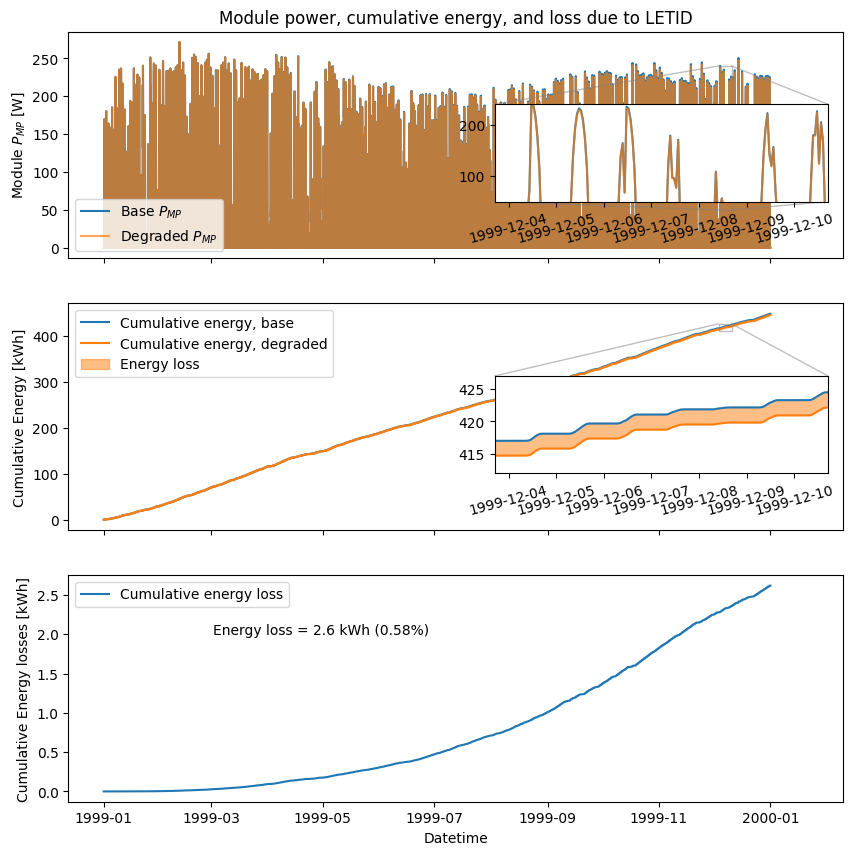

In [38]:
import matplotlib.dates as mdates 
from scipy.integrate import cumulative_trapezoid, simpson


fig, axs = plt.subplots(3, 1, figsize = (10,10), sharex = True)
ax1, ax2, ax3 = axs

ax1.plot(timesteps['Datetime'], timesteps["p_mp"], label = 'Base $P_{MP}$')
ax1.plot(timesteps['Datetime'], timesteps["p_mp"]*timesteps['Pmp_norm'], label = 'Degraded $P_{MP}$', alpha = 0.7)
ax1.legend(loc = 'lower left')

axin1 = ax1.inset_axes([.55, 0.25, 0.43, 0.43])
axin1.plot(timesteps['Datetime'], timesteps["p_mp"])
axin1.plot(timesteps['Datetime'], timesteps["p_mp"]*timesteps['Pmp_norm'], alpha = 0.7)


axin1.set_xlim(mdates.datestr2num('1999-12-04'), mdates.datestr2num('1999-12-11'))
axin1.set_ylim(50,240)
axin1.tick_params(axis='x', labelrotation = 15)
ax1.indicate_inset_zoom(axin1)

start = timesteps['Datetime'].iloc[0]
timesteps['Timedelta'] = [(d - start).total_seconds()/3600 for d in timesteps['Datetime']]

ax2.plot(timesteps['Datetime'], cumulative_trapezoid(timesteps["p_mp"]/1000, timesteps['Timedelta'], initial = 0), label = 'Cumulative energy, base')
ax2.plot(timesteps['Datetime'], cumulative_trapezoid((timesteps["p_mp"]*timesteps['Pmp_norm'])/1000, timesteps['Timedelta'], initial = 0), label = 'Cumulative energy, degraded')
ax2.fill_between(timesteps['Datetime'], (cumulative_trapezoid(timesteps["p_mp"], timesteps['Timedelta'], initial = 0)/1000), (cumulative_trapezoid(timesteps["p_mp"]*timesteps['Pmp_norm'], timesteps['Timedelta'], initial = 0)/1000), alpha = 0.5, color = 'C1', label = 'Energy loss')
ax2.legend()

axin2 = ax2.inset_axes([.55, 0.25, 0.43, 0.43])
axin2.plot(timesteps['Datetime'], cumulative_trapezoid(timesteps["p_mp"]/1000, timesteps['Timedelta'], initial = 0))
axin2.plot(timesteps['Datetime'], cumulative_trapezoid((timesteps["p_mp"]*timesteps['Pmp_norm'])/1000, timesteps['Timedelta'], initial = 0))
axin2.fill_between(timesteps['Datetime'], (cumulative_trapezoid(timesteps["p_mp"], timesteps['Timedelta'], initial = 0)/1000), (cumulative_trapezoid(timesteps["p_mp"]*timesteps['Pmp_norm'], timesteps['Timedelta'], initial = 0)/1000), alpha = 0.5, color = 'C1')

axin2.set_xlim(mdates.datestr2num('1999-12-04'), mdates.datestr2num('1999-12-11'))
axin2.set_ylim(412, 427)
axin2.tick_params(axis='x', labelrotation = 15)
ax2.indicate_inset_zoom(axin2)

ax3.set_xlabel('Datetime')
ax3.plot(timesteps['Datetime'], (cumulative_trapezoid(timesteps["p_mp"], timesteps['Timedelta'], initial = 0)/1000)-(cumulative_trapezoid(timesteps["p_mp"]*timesteps['Pmp_norm'], timesteps['Timedelta'], initial = 0)/1000), label = 'Cumulative energy loss')
ax3.legend()

loss = letid.calc_energy_loss(timesteps)
energy = simpson(timesteps["p_mp"]/1000, timesteps['Timedelta'])
ax3.text(mdates.datestr2num('1999-03-02'), 2, s = f"Energy loss = {loss*energy:.1f} kWh ({loss*100:.2f}%)")

ax1.set_ylabel('Module $P_{MP}$ [W]')
ax2.set_ylabel('Cumulative Energy [kWh]')
ax3.set_ylabel('Cumulative Energy losses [kWh]')

ax1.set_title('Module power, cumulative energy, and loss due to LETID')

plt.show()

##### The function `calc_letid_outdoors` wraps all of the steps above into a single function:

In [41]:
mechanism_params = 'repins'

letid.calc_letid_outdoors(tau_0, tau_deg,wafer_thickness, srv_rear, nA_0, nB_0, nC_0, weather, meta, mechanism_params, generation_df, module_parameters = cec_module)

,Datetime,Temperature,Injection,NA,NB,NC,tau,Jsc,Voc,Isc,FF,Pmp,Pmp_norm
0,1999-01-01 00:30:00-07:00,0.0,NaN,100.0,0.000000e+00,0.000000e+00,120.0,38.541512,0.659445,9.211421,0.839768,5.101107,1.0
1,1999-01-01 01:30:00-07:00,0.0,NaN,100.0,1.683090e-15,0.000000e+00,120.0,38.541512,0.659445,9.211421,0.839768,5.101107,1.0
2,1999-01-01 02:30:00-07:00,0.0,NaN,100.0,3.366181e-15,5.269266e-36,120.0,38.541512,0.659445,9.211421,0.839768,5.101107,1.0
3,1999-01-01 03:30:00-07:00,0.0,NaN,100.0,5.049271e-15,1.580780e-35,120.0,38.541512,0.659445,9.211421,0.839768,5.101107,1.0
4,1999-01-01 04:30:00-07:00,0.0,NaN,100.0,6.732362e-15,3.161560e-35,120.0,38.541512,0.659445,9.211421,0.839768,5.101107,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,1999-12-31 19:30:00-07:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.328504,NaN,NaN
8756,1999-12-31 20:30:00-07:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.328504,NaN,NaN
8757,1999-12-31 21:30:00-07:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.328504,NaN,NaN
8758,1999-12-31 22:30:00-07:00,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.328504,NaN,NaN
